Dask provides multi-core and distributed parallel execution on larger-than-memory datasets.

We can think of dask at a high and a low level

*  **High level collections:**  dask provides high-level Array, Bag, and DataFrame
   collections that mimic NumPy, lists, and Pandas but can operate in parallel on
   datasets that don't fit into memory.  Dask's high-level collections are
   alternatives to NumPy and Pandas for large datasets. Dask functions are 
   alternative to Spark and MapReduce.
   
*  **Low Level schedulers:** dask provides dynamic task schedulers that
   execute task graphs in parallel.  These execution engines power the
   high-level collections mentioned above but can also power custom,
   user-defined workloads.  These schedulers are low-latency (around 1ms) and
   work hard to run computations in a small memory footprint.  Dask's
   schedulers are an alternative to direct use of `threading` or
   `multiprocessing` libraries in complex cases or other task scheduling
   systems like `Luigi` or `IPython parallel`.
  
<img src="collections-schedulers.png" align="center" width="60%">

We are planning to use only scheduler, but in future we can incorporate MapReduce functionality of dask in mne-python. 


## Dependencies

Dask need the following core libraries

    conda install numpy pandas h5py Pillow matplotlib scipy toolz pytables fastparquet

Install dask distributed

    conda install dask distributed

The following is useful for task graph visualization

    conda install graphviz

We also need glob for reading directory contents

     conda install glob

In [1]:
%matplotlib inline
import mne
import glob
import timeit
import numpy as np
from dask import delayed
from dask.distributed import LocalCluster, Client
from mne.time_frequency import psd_multitaper
import matplotlib.pyplot as plt

# Reduce Verbosity
mne.set_log_level('WARNING')
# For the plot number of subjects to be processed in parallel
nsubjects_parallel = range(1,101,10)

In [2]:
# Reading Directory Structure
fif_files_path = '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47' \
'/cc700/meg/pipeline/release004/data_nomovecomp' \
'/aamod_meg_maxfilt_00001/*/rest/transdef_mf2pt2_rest_raw.fif'

files = glob.glob(fif_files_path)

In [3]:
print(files)

['/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC710566/rest/transdef_mf2pt2_rest_raw.fif', '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC620413/rest/transdef_mf2pt2_rest_raw.fif', '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC620005/rest/transdef_mf2pt2_rest_raw.fif', '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC210526/rest/transdef_mf2pt2_rest_raw.fif', '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC320680/rest/transdef_mf2pt2_rest_raw.fif', '/autofs/cluster/fusion/Sheraz/data/camcan/camcan47/cc700/meg/pipeline/release004/data_nomovecomp/aamod_meg_maxfilt_00001/CC410015/rest/transdef_mf2pt2_rest_raw.fif

In [4]:
print(len(files))

650


In [5]:
def compute_psd(fif_file):
    raw = mne.io.read_raw_fif(fif_file, preload=True)
    raw.crop(50, 51)
    picks = mne.pick_types(raw.info, meg='mag', eeg=False, 
                           eog=False, stim=False)
    psd, _ = psd_multitaper(raw, fmin=2, fmax=55, picks=picks, normalization="full")
    return np.log10(psd)

In [ ]:
# Sequential code on local Workstation 32 Nodes

time_elpased_sequential = []

for nsubjets in nsubjects_parallel:
    psds = []
    start_time = timeit.default_timer()
    
    for file in files[0:nsubjets]:
        psd = compute_psd(file)
        psds.append(psd)
    mean_psd = np.mean(psds)
    time_elpased_sequential.append(timeit.default_timer() - start_time)
    
print(time_elpased_sequential)    

In [ ]:
# Parallel Code  on local Scheduler 32 Nodes

cluster = LocalCluster()
client  = Client(cluster)

time_elpased_lparallel = []

for nsubjets in nsubjects_parallel:
    psds = []
    
    for file in files[0:nsubjets]:
        psd= delayed(compute_psd)(file)
        psds.append(psd)
        
    mean_psd_delayed = delayed(np.mean)(psds, axis=1)
    
    start_time = timeit.default_timer()
    mean_psd = client.compute(mean_psd_delayed)
    mean_psd = mean_psd.result()
    time_elpased_lparallel.append(timeit.default_timer() - start_time)
    
print(time_elpased_lparallel)

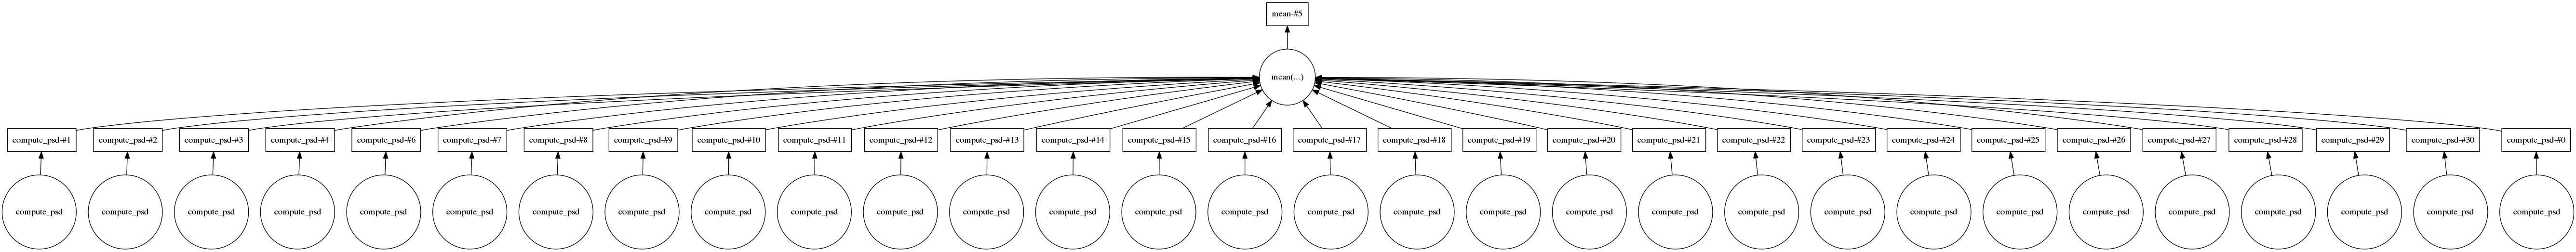

In [43]:
mean_psd_delayed.visualize()

In [ ]:
# Parallel Code  on Martinos Scheduler

client = Client('172.21.16.27:8786')

time_elpased_mparallel = []

for nsubjets in nsubjects_parallel:
    psds = []
    
    for file in files[0:nsubjets]:
        psd= delayed(compute_psd)(file)
        psds.append(psd)
        
    mean_psd_delayed = delayed(np.mean)(psds, axis=1)
    
    start_time = timeit.default_timer()
    mean_psd = client.compute(mean_psd_delayed)
    mean_psd = mean_psd.result()
    time_elpased_mparallel.append(timeit.default_timer() - start_time)
    
print(time_elpased_mparallel)

# Setup

## Get AWS setup

1. From https://boto3.readthedocs.io/en/latest/guide/quickstart.html (Boto is the Amazon Web Services (AWS) SDK for Python)

        sudo apt-get install awscli
        pip install boto3
2. Visit AWS -> IAM -> Add user -> Security Credentials -> Create Access Key
3. Run `aws configure` and enter the ID, code, region (us-east-1), outputformat (blank - leave as JSON)
4. Test with:

        import boto3
        s3 = boto3.resource('s3')
        for b in s3.buckets.all():
            print(b.name)
        
5. From http://distributed.readthedocs.io/en/latest/ec2.html,

        pip install dask-ec2

6. Visit AWS->EC2->Key pairs->Create key pair. I called mine "mitkey". Save the keyfile in .ssh, chmod 600.
7. Get the AMI we want to use (e.g. ubuntu 14.04). Check https://cloud-images.ubuntu.com/locator/ec2/ and search for e.g. `14.04 LTS us-east-1 hvm ebs`.
(Also found using ubuntu 16.04 had a SSL wrong version number error (see https://github.com/dask/dask-ec2/issues/38 )

## Running DASK

1. Run `dask-ec2 up --keyname YOUR-AWS-KEY --keypair ~/.ssh/YOUR-AWS-SSH-KEY.pem`. I found I had to also specify the region-name, the ami and tags as the first two have wrong defaults and the tool seems to fail if tags isn't set either.

E.g.

dask-ec2 up --keyname mitkey --keypair ~/keys/mit.pem  --ami ami-cee00cb4 --tags research:dp --type t2.large --count 2 --volume-size 30
      
Or greedy (8x36 = \$14.5/hour):

dask-ec2 up --keyname mitkey --keypair ~/keys/mit.pem  --ami ami-cee00cb4 --tags research:dp --type t2.large --count 30 --volume-size 30
        
Eventually after a long time, this will finish with:

        Dask.Distributed Installation succeeded

        Addresses
        ---------
        Web Interface:    http://54.246.253.159:8787/status
        TCP Interface:           54.246.253.159:8786

        To connect from the cluster
        ---------------------------

        dask-ec2 ssh  # ssh into head node
        ipython  # start ipython shell

        from dask.distributed import Client, progress
        c = Client('127.0.0.1:8786')  # Connect to scheduler running on the head node

        To connect locally
        ------------------

        Note: this requires you to have identical environments on your local machine and cluster.

        ipython  # start ipython shell

        from dask.distributed import Client, progress
        e = Client('54.246.253.159:8786')  # Connect to scheduler running on the head node

        To destroy
        ----------

        dask-ec2 destroy
        Installing Jupyter notebook on the head node
        DEBUG: Uploading file /tmp/tmp1GOH7d to /tmp/.__tmp_copy
        DEBUG: Running command sudo -S bash -c 'cp -rf /tmp/.__tmp_copy /srv/pillar/jupyter.sls' on '54.246.253.159'
        DEBUG: Running command sudo -S bash -c 'rm -rf /tmp/.__tmp_copy' on '54.246.253.159'
        +---------+----------------------+-----------------+
        | Node ID | # Successful actions | # Failed action |
        +=========+======================+=================+
        | node-0  | 17                   | 0               |
        +---------+----------------------+-----------------+
        Jupyter notebook available at http://54.246.253.159:8888/ 
        Login with password: jupyter



